<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 3 and 4, 2018: types definitions, gfs
</small>
</div>
</p>
<br>
<div align="center">
<b>Abstract</b><br>
In this document we collect a naive <i>type system</i> based on sets.
</div>

In [1]:
from functools import lru_cache, reduce
import itertools
import operator, math

from sympy import *

In [2]:
%run src/commons.py

---

In [3]:
init_printing()

In [4]:
x,y,m,t,z = symbols('x y m t z')
alpha, beta, gamma, eta = symbols(r'\alpha \beta \gamma \eta')
f,g = Function('f'), Function('g')
w = IndexedBase('w')

---

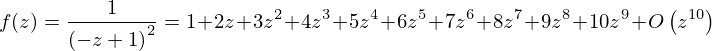

In [5]:
define(f(z), (1/(1-z))*(1/(1-z)), ctor=FEq).series(z,n=10,is_exp=False)

In [19]:
define(f(z), z**3,ctor=FEq).series(z, n=10, is_exp=True)

In [21]:
define(f(z), exp(z),ctor=FEq).series(z, n=10, is_exp=True)

In [23]:
define(f(z), z*exp(z), ctor=FEq).series(z, n=10, is_exp=True)

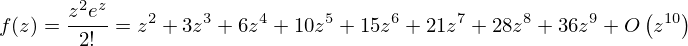

In [29]:
define(f(z), z**2*exp(z)/factorial(2,evaluate=False), 
       ctor=FEq).series(z, n=10, is_exp=True)

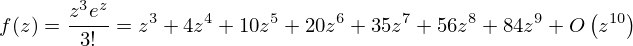

In [28]:
define(f(z), z**3*exp(z)/factorial(3, evaluate=False), 
       ctor=FEq).series(z, n=10, is_exp=True)

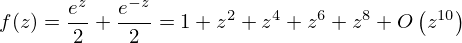

In [30]:
define(f(z), (exp(z)+exp(-z))/2, ctor=FEq).series(z, n=10, is_exp=True)

In [31]:
define(f(z), exp(m*z), ctor=FEq).series(z, n=10, is_exp=True)

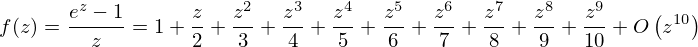

In [34]:
define(f(z), (exp(z)-1)/z, ctor=FEq).series(z, n=10, is_exp=True)

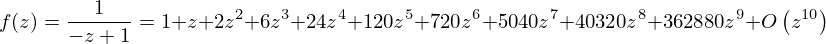

In [35]:
define(f(z), 1/(1-z), ctor=FEq).series(z, n=10, is_exp=True)

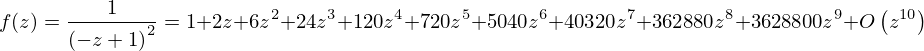

In [36]:
define(f(z), (1/(1-z))*(1/(1-z)), ctor=FEq).series(z, n=10,is_exp=True)

In [37]:
define(f(z), exp(z)**2, ctor=FEq).series(z, n=10, is_exp=True)

---

In [38]:
class ty:
    
    def __init__(self, *types):
        self.types = types # the list of types that I depend on.
    
    def tyvars(self):
        vs = map(operator.methodcaller('tyvars'), self.types)
        return reduce(operator.or_, vs, set())
    
    def label(self):
        raise NotImplemented # I'm an abstract type, nameless indeed.
    
    def gf_lhs(self):
        L = Function(self.label())
        return L(*self.tyvars())
    
    def gf(self):
        return [define(self.gf_lhs(), rhs, ctor=FEq) 
                for rhs in self.gf_rhs(*self.types)]
        
    def gf_rhs(self, *types):
        return self.definition(*types).gf_rhs(*types)
    
    def definition(self, *types):
        raise NotImplemented
        
    def gfs_space(self):
        return itertools.product(*map(lambda ty: ty.gf(), self.types))
    
    def __or__(self, other):
        return du(self, other)
    
    def __mul__(self, other):
        return cp(self, other)
    
    def __rpow__(self, base):
        if base == 2:
            return powerset(self)
        raise ValueError

In [45]:
class cp(ty):
        
    def gf_rhs(self, *types):
        return [reduce(lambda acc, gf: gf.rhs * acc, gfs, 1) 
                for gfs in self.gfs_space()]
        
    def label(self):
        return r'\times'

In [52]:
class du(ty):
    
    def label(self):
        return r'\cup'
            
    def gf_rhs(self, *types):
        return [reduce(lambda acc, gf: gf.rhs + acc, gfs, 0) 
                for gfs in self.gfs_space()]

In [53]:
class tyvar(ty):
    
    def label(self):
        return r'\mathcal{V}'
        
    def gf_rhs(self, sym):
        return [sym]
    
    def tyvars(self):
        sym, = self.types
        args = sym.args
        return set(filter(lambda a: a.is_symbol, args)) if args else set([sym])

In [54]:
tyvar(x).gf()

In [55]:
(tyvar(x) * tyvar(y) * tyvar(z)).gf()

In [56]:
(tyvar(x) | tyvar(y) | tyvar(z)).gf()

In [57]:
boolean = tyvar(x) | tyvar(y)

In [58]:
boolean.gf()

In [62]:
class maybe(ty):
    
    def definition(self, alpha):
        return cp() | alpha
    
    def label(self):
        return r'\mathcal{M}'

In [63]:
maybe(tyvar(alpha)).gf()

In [160]:
class rec(ty):
    
    def me(self):
        return tyvar(self.gf_lhs())
    
    def gf(self):
        eqs = super().gf()
        return [define(eq.lhs, sol, ctor=FEq) 
                for eq in eqs
                for sol in solve(define(eq.lhs, eq.rhs), [eq.lhs])]

def constraints(gfs, rules={}):
    res = []
    for gf in gfs:
        for k,v in rules.items():
            w = gf(*k)
            print(w,v)
            if w != v: 
                break
        else:  
            res.append(gf)
    return res

In [161]:
class lst(rec):
         
    def definition(self, alpha):
        return cp() | (alpha * self.me())
    
    def label(self):
        return r'\mathcal{L}'

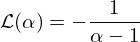

In [148]:
lst_of_alpha_gf, = lst(tyvar(alpha)).gf()
lst_of_alpha_gf

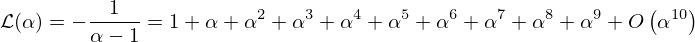

In [149]:
lst_of_alpha_gf.series(alpha, n=10)

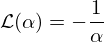

In [150]:
lst_of_maybe_of_alpha_gf, = lst(maybe(tyvar(alpha))).gf()
lst_of_maybe_of_alpha_gf

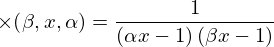

In [151]:
nats = (lst(tyvar(alpha*x)) * lst(tyvar(beta*x)))
nats_gf, = nats.gf()
nats_gf

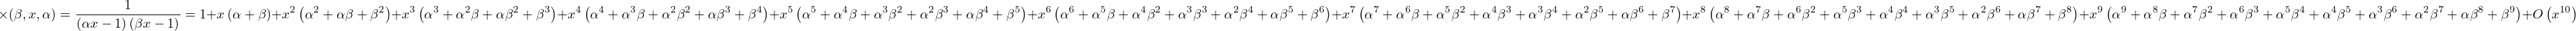

In [152]:
nats_gf.series(x, n=10)

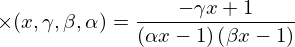

In [113]:
difference = (cp() | tyvar(-gamma*x))
ones = nats * difference
ones_gf, = ones.gf()
ones_gf

In [118]:
ones_gf(x,1,1,1).series(x, n=10) # check!

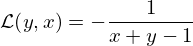

In [119]:
lst_of_boolean_gf, = lst(boolean).gf()
lst_of_boolean_gf

In [120]:
lst_of_boolean_gf(t,t).series(t,n=10)

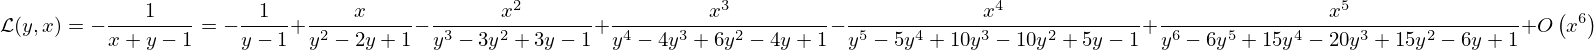

In [122]:
s = lst_of_boolean_gf.series(x)
s

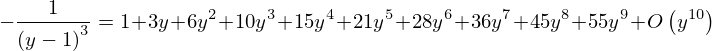

In [124]:
s2 = s.rhs.rhs.coeff(x,2).factor()
Eq(s2, s2.series(y,n=10))

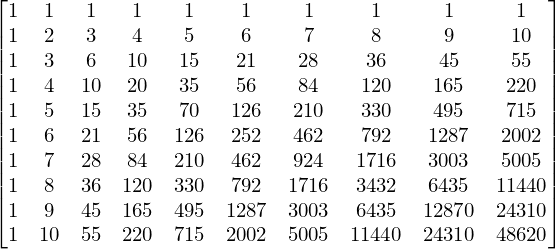

In [125]:
dim = 10

@lru_cache(maxsize=None)
def col(j):
    return lst_of_boolean_gf.rhs.series(x,n=dim).coeff(x,j).series(y,n=dim)

Matrix(dim, dim, lambda i,j: col(j).coeff(y,i))

In [126]:
class nnlst(rec):
         
    def definition(self, alpha):
        return alpha | (alpha * self.me())
    
    def label(self):
        return r'\mathcal{L}_{+}'

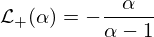

In [128]:
nnlst_of_alpha_gf, = nnlst(tyvar(alpha)).gf()
nnlst_of_alpha_gf

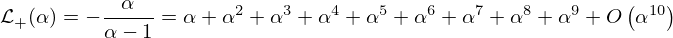

In [129]:
nnlst_of_alpha_gf.series(alpha, n=10)

In [162]:
class bin_tree(rec):
    
    def definition(self, alpha):
        return cp() | (alpha * self.me() * self.me())
    
    def label(self):
        return r'\mathcal{B}'

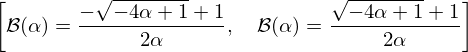

In [163]:
bin_tree_gfs = bin_tree(tyvar(alpha)).gf()
bin_tree_gfs

In [165]:
bin_tree_gf = bin_tree_gfs[0]

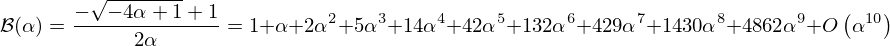

In [166]:
bin_tree_gf.series(alpha, n=10)

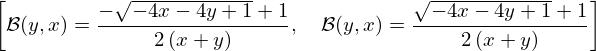

In [170]:
bin_tree_of_boolean_gfs = bin_tree(boolean).gf()
bin_tree_of_boolean_gfs

In [171]:
bin_tree_of_boolean_gf = bin_tree_of_boolean_gfs[0]
s = bin_tree_of_boolean_gf.series(x)

In [174]:
coeffs = [s.rhs.rhs.coeff(x,i).simplify() for i in range(6)]

In [175]:
ys = [c.series(y) for c in coeffs]
ys

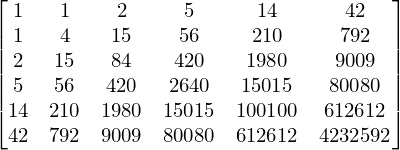

In [176]:
dim = 6

@lru_cache(maxsize=None)
def col(j):
    return s.coeff(x,j).simplify().series(y,n=dim)

Matrix(dim, dim, lambda i,j: ys[i].coeff(y,j))

In [179]:
occupancy, = cp(*[cp() | tyvar(w[i]*x) for i in range(3)]).gf()
occupancy

In [180]:
occupancy.series(x)

In [185]:
o = occupancy(x,1,1,1)
define(o, o.expand())

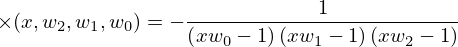

In [186]:
occupancy, = cp(*[lst(tyvar(w[i]*x)) for i in range(3)]).gf()
occupancy

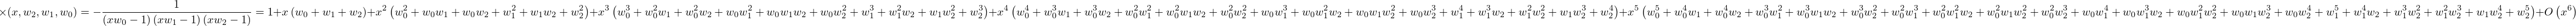

In [187]:
occupancy.series(x)

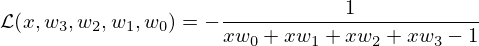

In [189]:
occupancy, = lst(tyvar(w[0]*x) | tyvar(w[1]*x) | tyvar(w[2]*x) | tyvar(w[3]*x)).gf()
occupancy

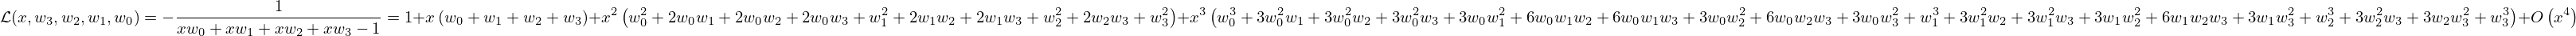

In [191]:
occupancy.series(x, n=4)

In [192]:
class lst_structure_w(rec):
         
    def definition(self, alpha):
        me = self.me()
        return alpha | lst(me)
    
    def label(self):
        return r'\mathcal{L}_{w}' # `_s` stands for "structure"

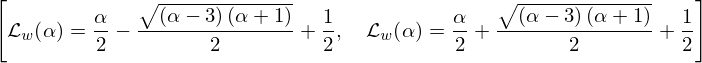

In [193]:
lst_structure_w(tyvar(alpha)).gf()

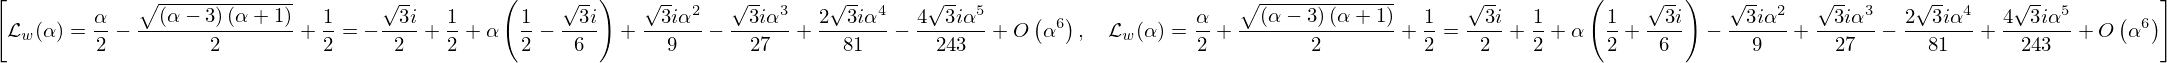

In [194]:
[gf.series(alpha) for gf in _]

In [195]:
class lst_structure(rec):
         
    def definition(self, alpha):
        me = self.me()
        return alpha | (lst(me) * me * me)
    
    def label(self):
        return r'\mathcal{L}_{s}' # `_s` stands for "structure"

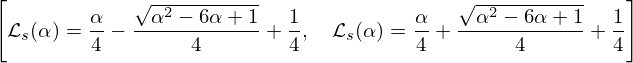

In [197]:
lst_structure(tyvar(alpha)).gf()

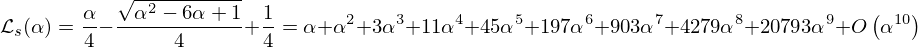

In [198]:
_[0].series(alpha, n=10)

In [199]:
class nnlst_structure(rec):
         
    def definition(self, alpha):
        me = self.me()
        return alpha * lst(nnlst(me))
    
    def label(self):
        return r'\mathcal{L}_{s}^{+}' # `_s` stands for "structure"

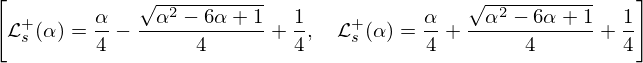

In [201]:
nnlst_structure(tyvar(alpha)).gf()

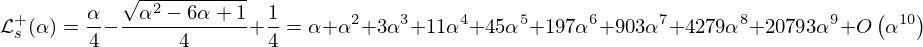

In [202]:
_[0].series(alpha, n=10)

In [203]:
class tree(rec):
         
    def definition(self, alpha):
        return alpha * lst(self.me())
    
    def label(self):
        return r'\mathcal{T}'

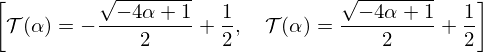

In [204]:
tree(tyvar(alpha)).gf()

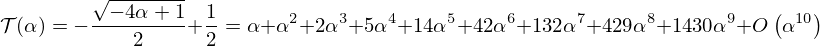

In [205]:
_[0].series(alpha, n=10)

In [206]:
class combination(rec):
         
    def definition(self, alpha):
        me = self.me()
        return alpha | (me * me)
    
    def label(self):
        return r'\mathcal{C}'

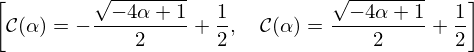

In [209]:
combination(tyvar(alpha)).gf()

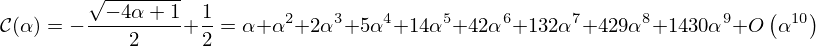

In [210]:
_[0].series(alpha, n=10)

In [211]:
class ab_tree(rec):
         
    def definition(self, alpha, beta):
        me = self.me()
        return beta | (alpha * me * me)
    
    def label(self):
        return r'\mathcal{T}_{a,b}'

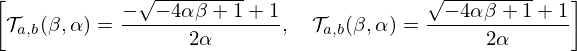

In [212]:
ab_tree_gfs = ab_tree(tyvar(alpha), tyvar(beta)).gf()
ab_tree_gfs

In [213]:
ab_tree_gf = ab_tree_gfs[0]

In [214]:
fab_eq = FEq(ab_tree_gf.lhs, ab_tree_gf.rhs.series(beta, n=20).removeO(), evaluate=False)
fab_eq

In [215]:
fab_eq(x,x)

In [216]:
(_*alpha).expand()

In [217]:
#with lift_to_Lambda(fab_eq) as F:
B = fab_eq(x,1)
A = fab_eq(1,x)
A,B,

In [218]:
(A+B).expand()

In [219]:
((1+x)*A).expand()

In [223]:
class dyck(rec):
         
    def definition(self, alpha, beta):
        me = self.me()
        return cp() | (alpha * me * beta * me)
    
    def label(self):
        return r'\mathcal{D}'

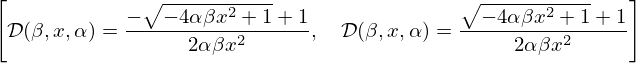

In [225]:
dyck_gfs = dyck(tyvar(alpha*x), tyvar(beta*x)).gf()
dyck_gfs

In [226]:
dyck_gf = dyck_gfs[0]

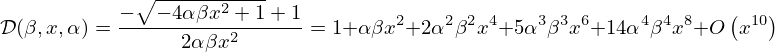

In [229]:
dyck_gf.series(x,n=10)

In [233]:
class motzkin(rec):
         
    def definition(self, alpha, beta, gamma):
        me = self.me()
        return cp() | (alpha * me * beta * me) | (gamma * me)
    
    def label(self):
        return r'\mathcal{M}'

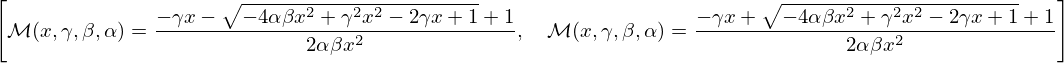

In [235]:
motzkin_gfs = motzkin(tyvar(alpha*x), tyvar(beta*x), tyvar(gamma*x),).gf()
motzkin_gfs

In [236]:
motzkin_gf = motzkin_gfs[0]

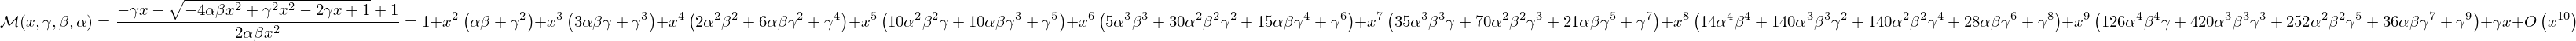

In [237]:
motzkin_gf.series(x,n=10)

In [238]:
motzkin_gf(x,1,1,1).series(x,n=10)

In [239]:
class motzkin_p(rec):
         
    def definition(self, alpha, beta, gamma, eta):
        me = self.me()
        return cp() | (alpha * me * beta * me) | (gamma * me) | (eta * me)
    
    def label(self):
        return r'\mathcal{M}^{+}'

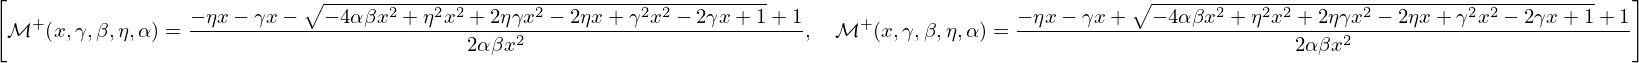

In [241]:
motzkinp_gfs = motzkin_p(tyvar(alpha*x), tyvar(beta*x), tyvar(gamma*x), tyvar(eta*x),).gf()
motzkinp_gfs

In [242]:
motzkinp_gf = motzkin_gfs[0]

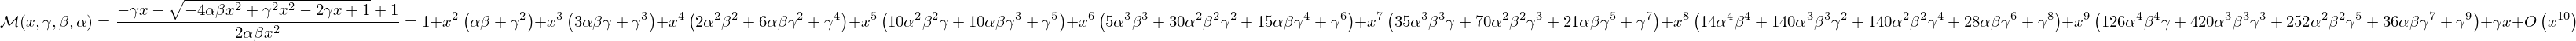

In [243]:
motzkinp_gf.series(x,n=10)

In [244]:
motzkinp_gf(x,1,1,1).series(x,n=10)

In [245]:
class fibo(rec):
         
    def definition(self, alpha, beta):
        me = self.me()
        return cp() | alpha | ((beta | (alpha * beta)) * me)
    
    def label(self):
        return r'\mathcal{F}'

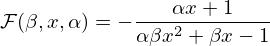

In [248]:
fibo_gf, = fibo(tyvar(alpha*x), tyvar(beta*x),).gf()
fibo_gf

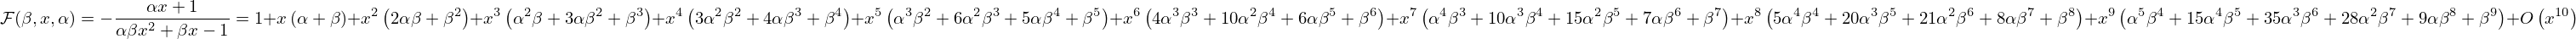

In [249]:
fibo_gf.series(x,n=10)

In [250]:
fibo_gf(1,x,1).series(x,n=10)

In [258]:
class powerset(ty):
         
    def gf_rhs(self, ty):
        return [exp(gf.rhs) for gf in ty.gf()]
    
    def label(self):
        return r'\mathcal{P}'

In [269]:
powerset_of_tyvar_gf, = (2**(nnlst(tyvar(alpha)))).gf()
powerset_of_tyvar_gf

In [270]:
powerset_of_tyvar_gf.series(alpha, n=10, is_exp=True)

In [273]:
powerset_of_tyvar_gf, _ = (2**(bin_tree(tyvar(alpha)))).gf()
powerset_of_tyvar_gf

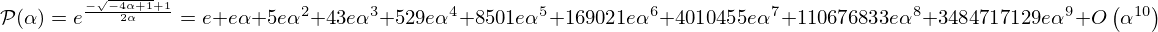

In [274]:
powerset_of_tyvar_gf.series(alpha, n=10, is_exp=True)

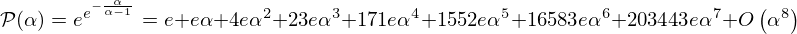

In [288]:
l, = (2**(2**(nnlst(tyvar(alpha))))).gf()
define(l.lhs, l.rhs.ratsimp(), ctor=FEq).series(alpha,n=8,is_exp=True)

---

In [291]:
class lamda(rec):
         
    def definition(self, gamma):
        me = self.me()
        return gamma | (me * me) | ((2**gamma) * (2**me))
    
    def label(self):
        return r'\mathcal{L}_{\Gamma}'

In [292]:
lamda_gf = lamda(tyvar(x)).gf()
lamda_gf

NotImplementedError: multiple generators [_X0, exp(_X0)]
No algorithms are implemented to solve equation -_X0**2 + _X0 - x - exp(_X0)*exp(x)

In [112]:
lamda_gf.rhs.series(x,n=10)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.